In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To build classification models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For tuning the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Reading files
path = '../datasets/'

travel_train = pd.read_csv(path + 'Traveldata_train.csv')
survey_train = pd.read_csv(path + 'Surveydata_train.csv')
travel_test = pd.read_csv(path + 'Traveldata_test.csv')
survey_test = pd.read_csv(path + 'Surveydata_test.csv')

datasets = [travel_train, survey_train, travel_test, survey_test]

for df in datasets:
    print(df.shape)

(94379, 9)
(94379, 17)
(35602, 9)
(35602, 16)


In [7]:
def merge_dfs(travel_df, survey_df):
    result_df = travel_df.merge(survey_df, how='outer', on='ID', indicator=True)
    return result_df

In [8]:
train_df = merge_dfs(travel_train,survey_train)
test_df = merge_dfs(travel_test,survey_test)

# checking for missing values

In [14]:
round(train_df.isna().sum() / train_df.shape[0] * 100,2).sort_values(ascending=False)

Type_Travel                9.78
Customer_Type              9.48
Arrival_Time_Convenient    9.46
Catering                   9.26
Onboard_Service            8.05
Arrival_Delay_in_Mins      0.38
Baggage_Handling           0.15
Legroom                    0.10
Online_Support             0.10
CheckIn_Service            0.08
Gender                     0.08
Ease_of_Online_Booking     0.08
Departure_Delay_in_Mins    0.06
Seat_Comfort               0.06
Age                        0.03
Platform_Location          0.03
Onboard_Wifi_Service       0.03
Onboard_Entertainment      0.02
Online_Boarding            0.01
Cleanliness                0.01
ID                         0.00
Seat_Class                 0.00
Overall_Experience         0.00
Travel_Distance            0.00
Travel_Class               0.00
_merge                     0.00
dtype: float64

In [16]:
round(test_df.isna().sum() / test_df.shape[0] * 100,2).sort_values(ascending=False)

Type_Travel                9.68
Customer_Type              9.50
Catering                   9.43
Arrival_Time_Convenient    9.34
Onboard_Service            8.07
Arrival_Delay_in_Mins      0.35
Baggage_Handling           0.11
Gender                     0.08
Departure_Delay_in_Mins    0.08
Online_Support             0.07
Legroom                    0.07
Seat_Comfort               0.06
CheckIn_Service            0.06
Ease_of_Online_Booking     0.05
Platform_Location          0.03
Onboard_Wifi_Service       0.03
Age                        0.03
Onboard_Entertainment      0.02
Cleanliness                0.01
Online_Boarding            0.01
ID                         0.00
Seat_Class                 0.00
Travel_Distance            0.00
Travel_Class               0.00
_merge                     0.00
dtype: float64

<AxesSubplot:>

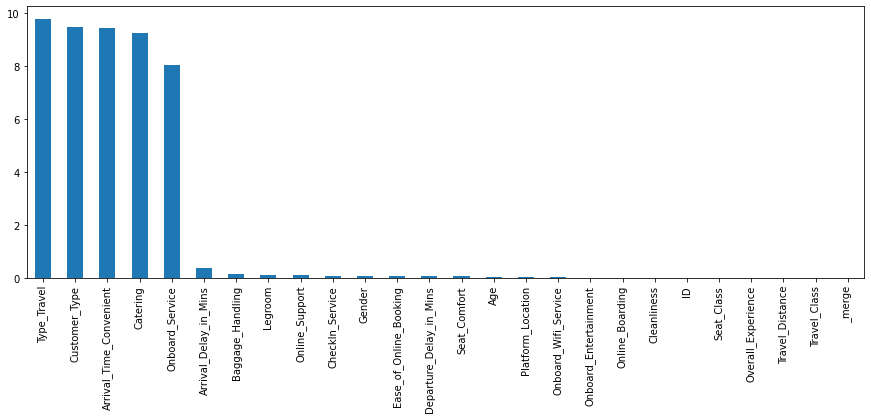

In [20]:
round(train_df.isna().sum() / train_df.shape[0] * 100,2).sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

<AxesSubplot:>

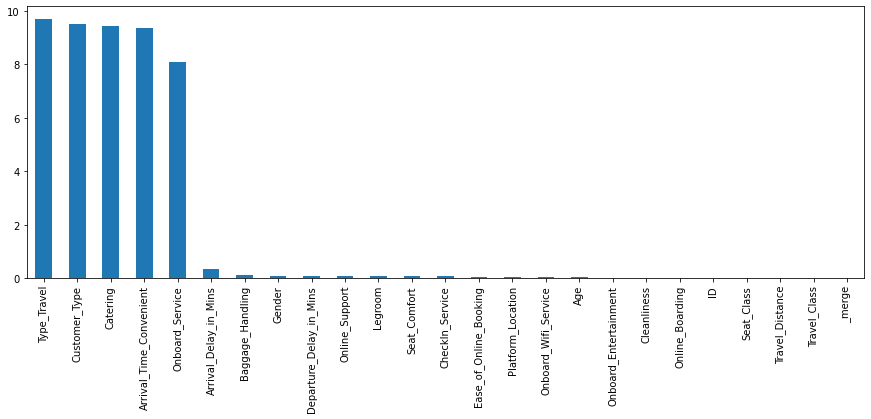

In [21]:
round(test_df.isna().sum() / test_df.shape[0] * 100,2).sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

Missing values in train and test datasets are proportional.

For columns 'Type_Travel', 'Customer_Type', 'Catering', 'Arrival_Time_Convenient','Onboard_Service' (top 5 columns with missing values) we could treat missing values as a another category.

# plotting distributions

In [27]:
num_cols = test_df.describe().columns.tolist() # extracting num cols with test_df since there's no Overall_Experience
cat_cols = test_df.describe(include='object').columns.tolist()

## num cols for train_df

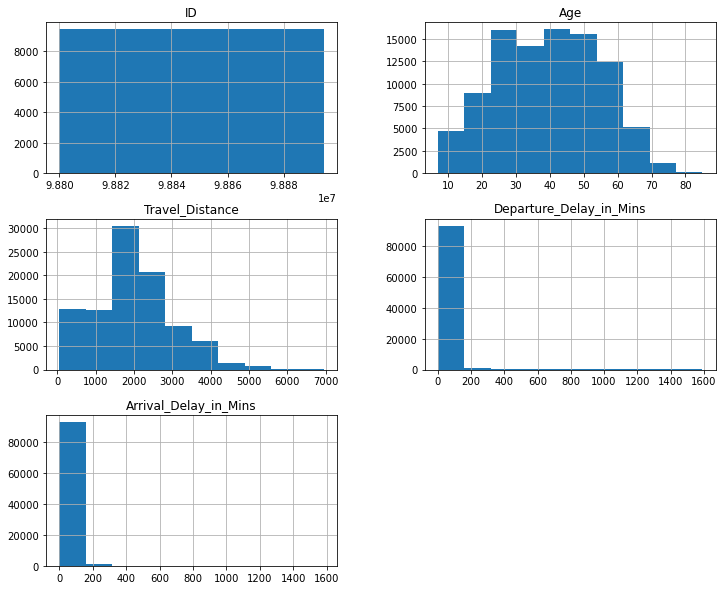

In [28]:
# showing numerical data
train_df[num_cols].hist(figsize=(12,10))
plt.show()

## num cols for test_df

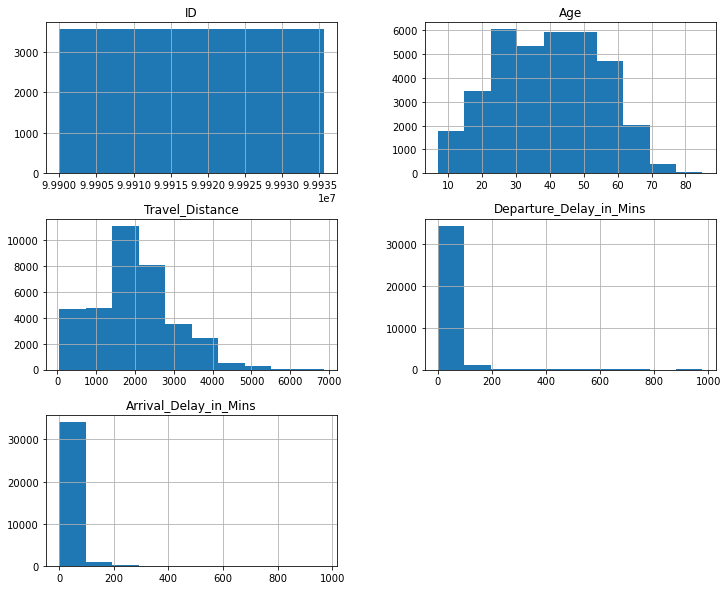

In [30]:
# showing numerical data
test_df[num_cols].hist(figsize=(12,10))
plt.show()

Almost identical distributions.

## cat cols for train_df

In [35]:
train_df['Type_Travel'].fillna('NA').value_counts()

Business Travel    58617
Personal Travel    26536
NA                  9226
Name: Type_Travel, dtype: int64

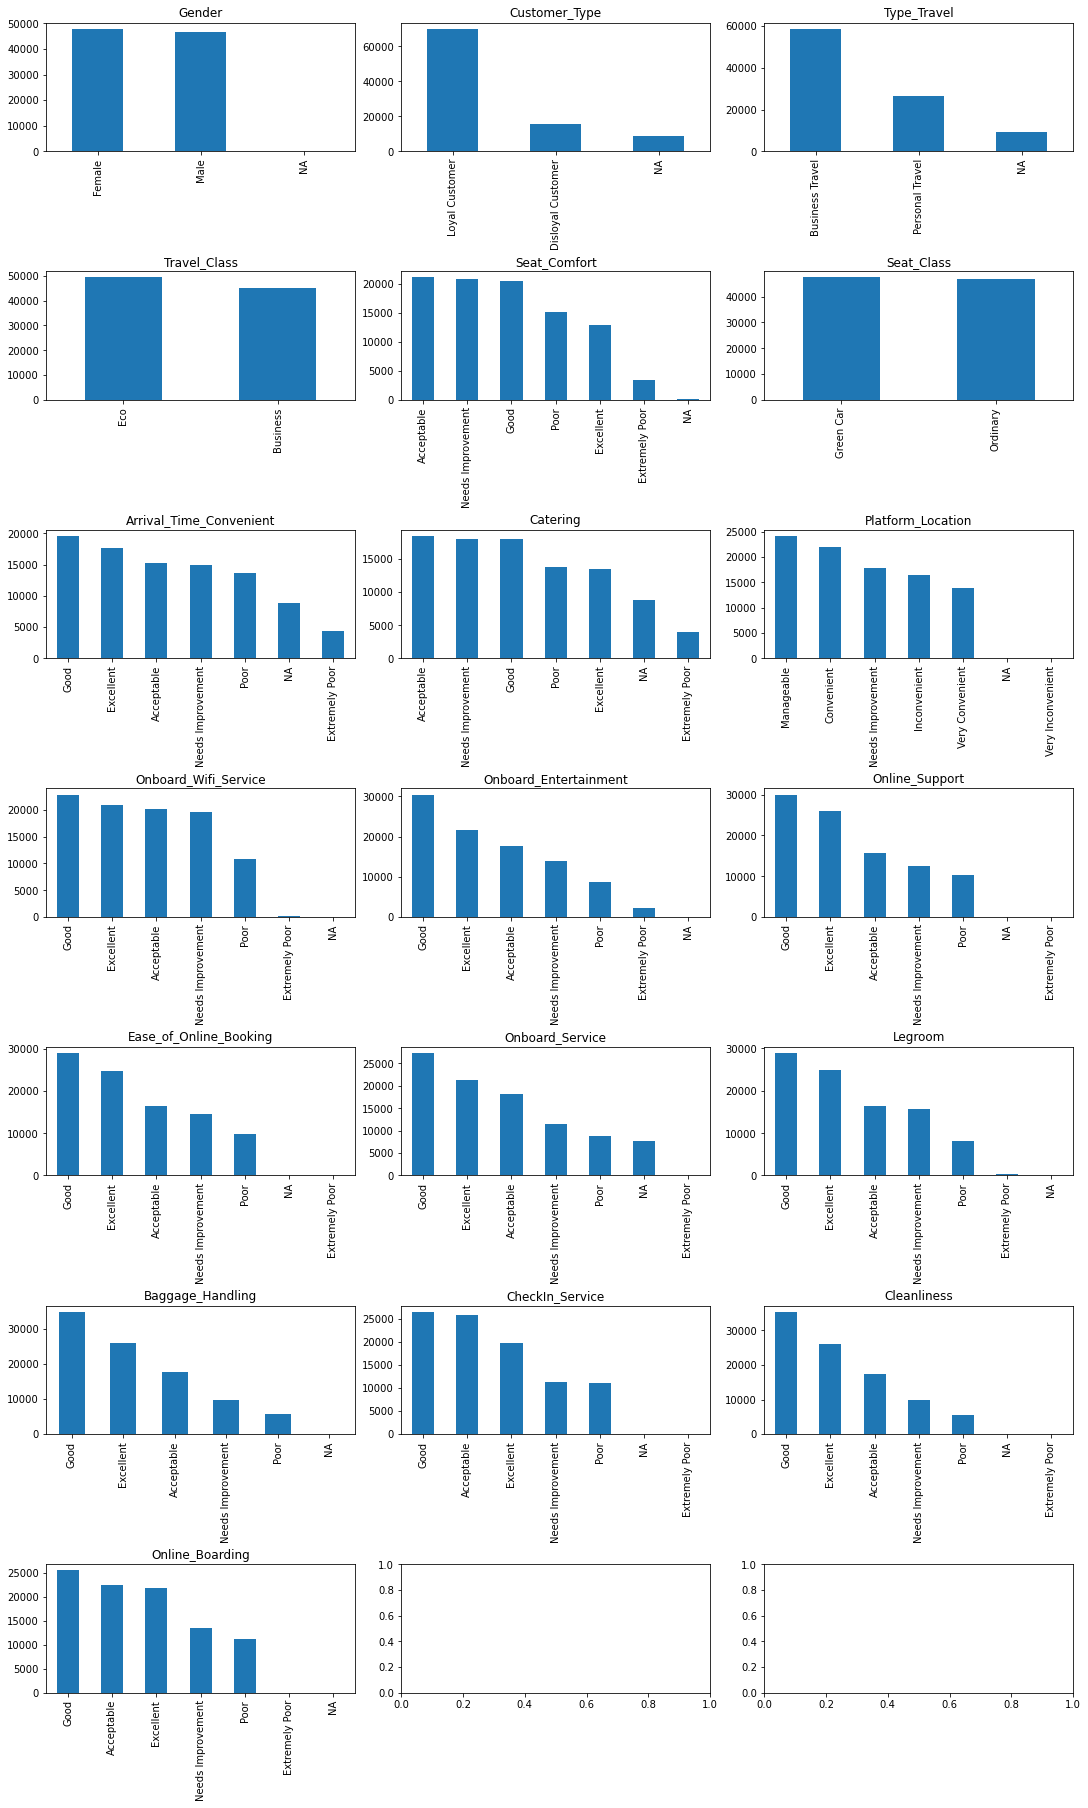

In [37]:
# assuming you have 21 columns:
fig,axes = plt.subplots(nrows=7, ncols=3, figsize=(15,25), constrained_layout=True)

# use `select_dtypes` to filter Object-type
for col, ax in zip(train_df.select_dtypes(include='O'), axes.ravel()):
    train_df[col].fillna('NA').value_counts().plot.bar(ax=ax)
    ax.set_title(col)
    
plt.show()

## cat cols for test_df

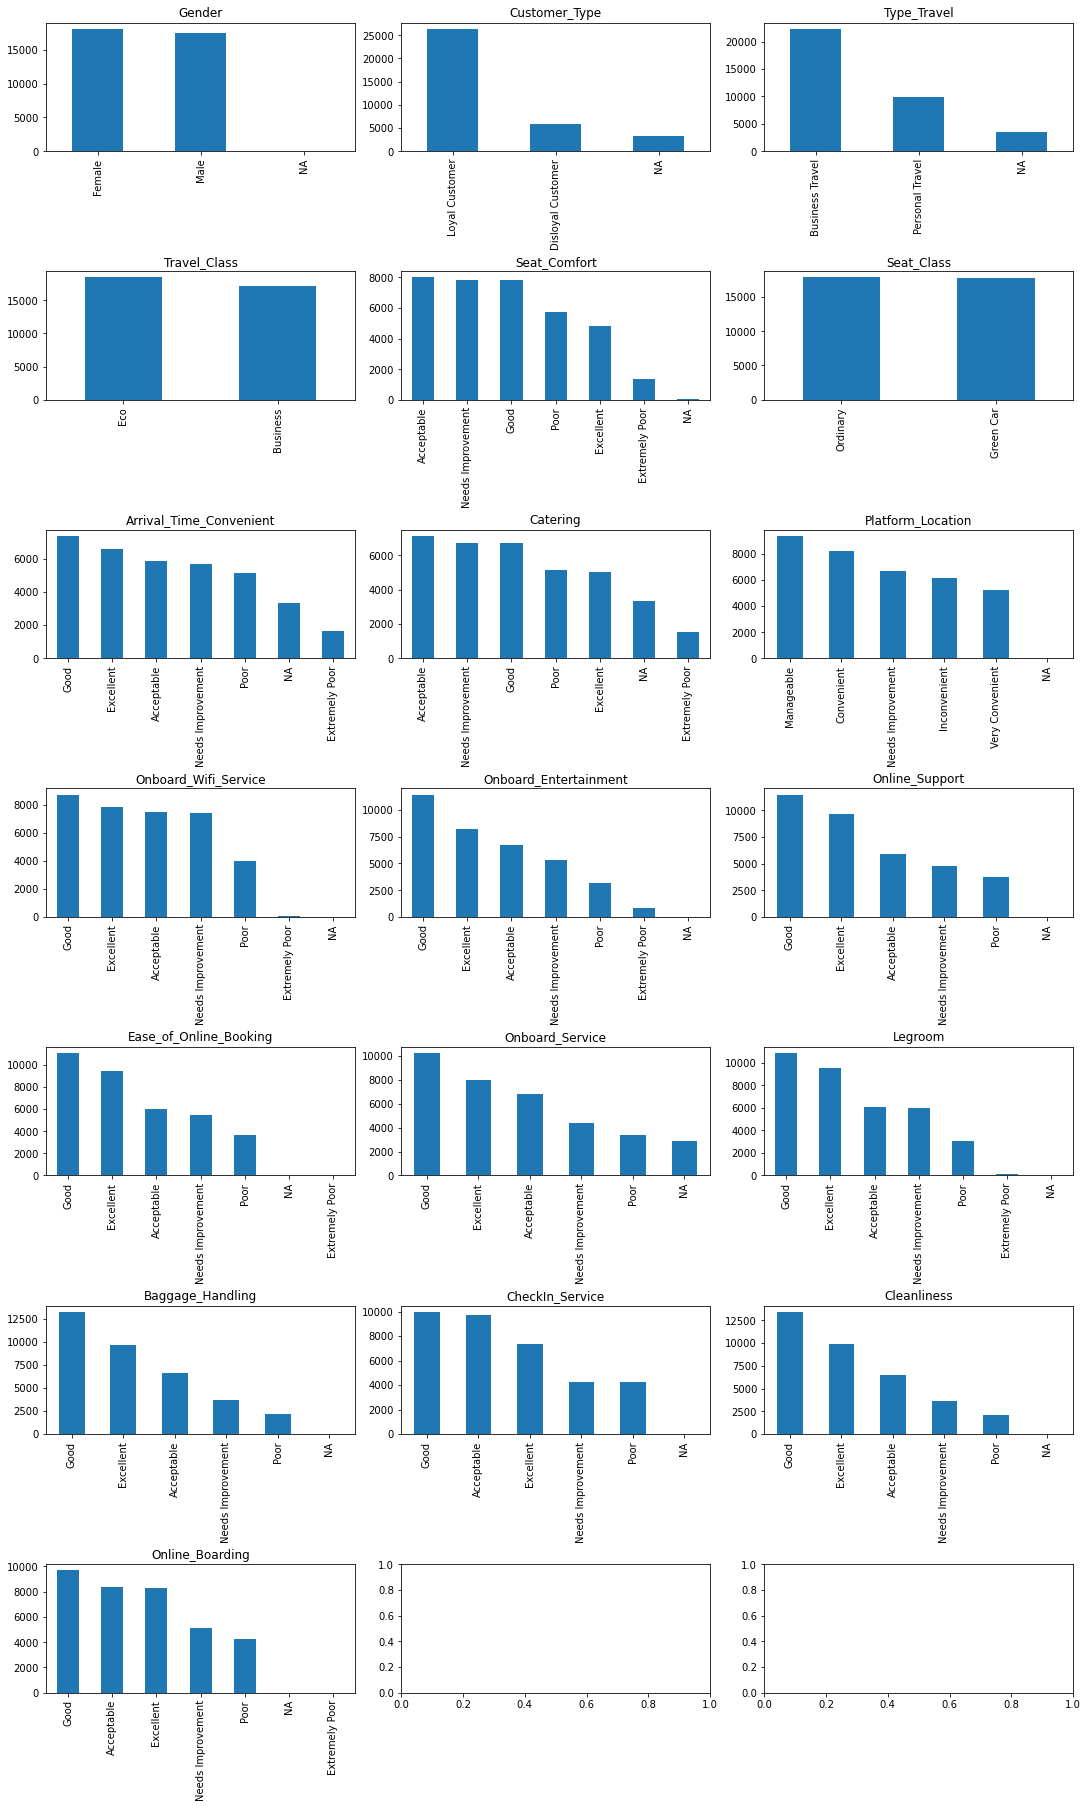

In [38]:
# assuming you have 21 columns:
fig,axes = plt.subplots(nrows=7, ncols=3, figsize=(15,25), constrained_layout=True)

# use `select_dtypes` to filter Object-type
for col, ax in zip(test_df.select_dtypes(include='O'), axes.ravel()):
    test_df[col].fillna('NA').value_counts().plot.bar(ax=ax)
    ax.set_title(col)
    
plt.show()

Categorical columns also present almost exact distributions between train and test dfs.

# reducing categorical variables

In [66]:
def cat_reducer(df):
    '''Reduced the categories of some categorical columns.'''
    
    reducer = {'Excellent':'positive',
                'Good':'positive',
                'Acceptable':'positive',
                'Needs Improvement':'negative',
                'Poor':'negative',
                'Extremely Poor':'negative'}

    platform_reducer = {'Very Convenient':'positive',
                        'Convenient':'positive',
                        'Manageable':'neutral',
                        'Needs Improvement':'negative',
                        'Inconvenient':'negative'}

    for col in cat_cols:
        
        # skipping cat cols that don't need reducing.
        if col in ['Gender','Customer_Type','Type_Travel','Travel_Class','Seat_Class']:
            pass
        
        elif col == 'Platform_Location':      
            simple_train_df[col] = simple_train_df[col].map(platform_reducer)
            
        else: 
            simple_train_df[col] = simple_train_df[col].map(reducer)

In [68]:
simple_train_df = train_df.copy()

cat_reducer(simple_train_df)
simple_train_df.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,_merge
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0,0,...,negative,positive,negative,negative,positive,negative,positive,negative,negative,both
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0,0,...,negative,positive,positive,positive,negative,negative,negative,positive,positive,both
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0,1,...,positive,positive,positive,positive,positive,positive,positive,positive,positive,both
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0,0,...,negative,positive,positive,positive,positive,positive,positive,positive,positive,both
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0,1,...,positive,positive,positive,positive,positive,positive,positive,positive,positive,both


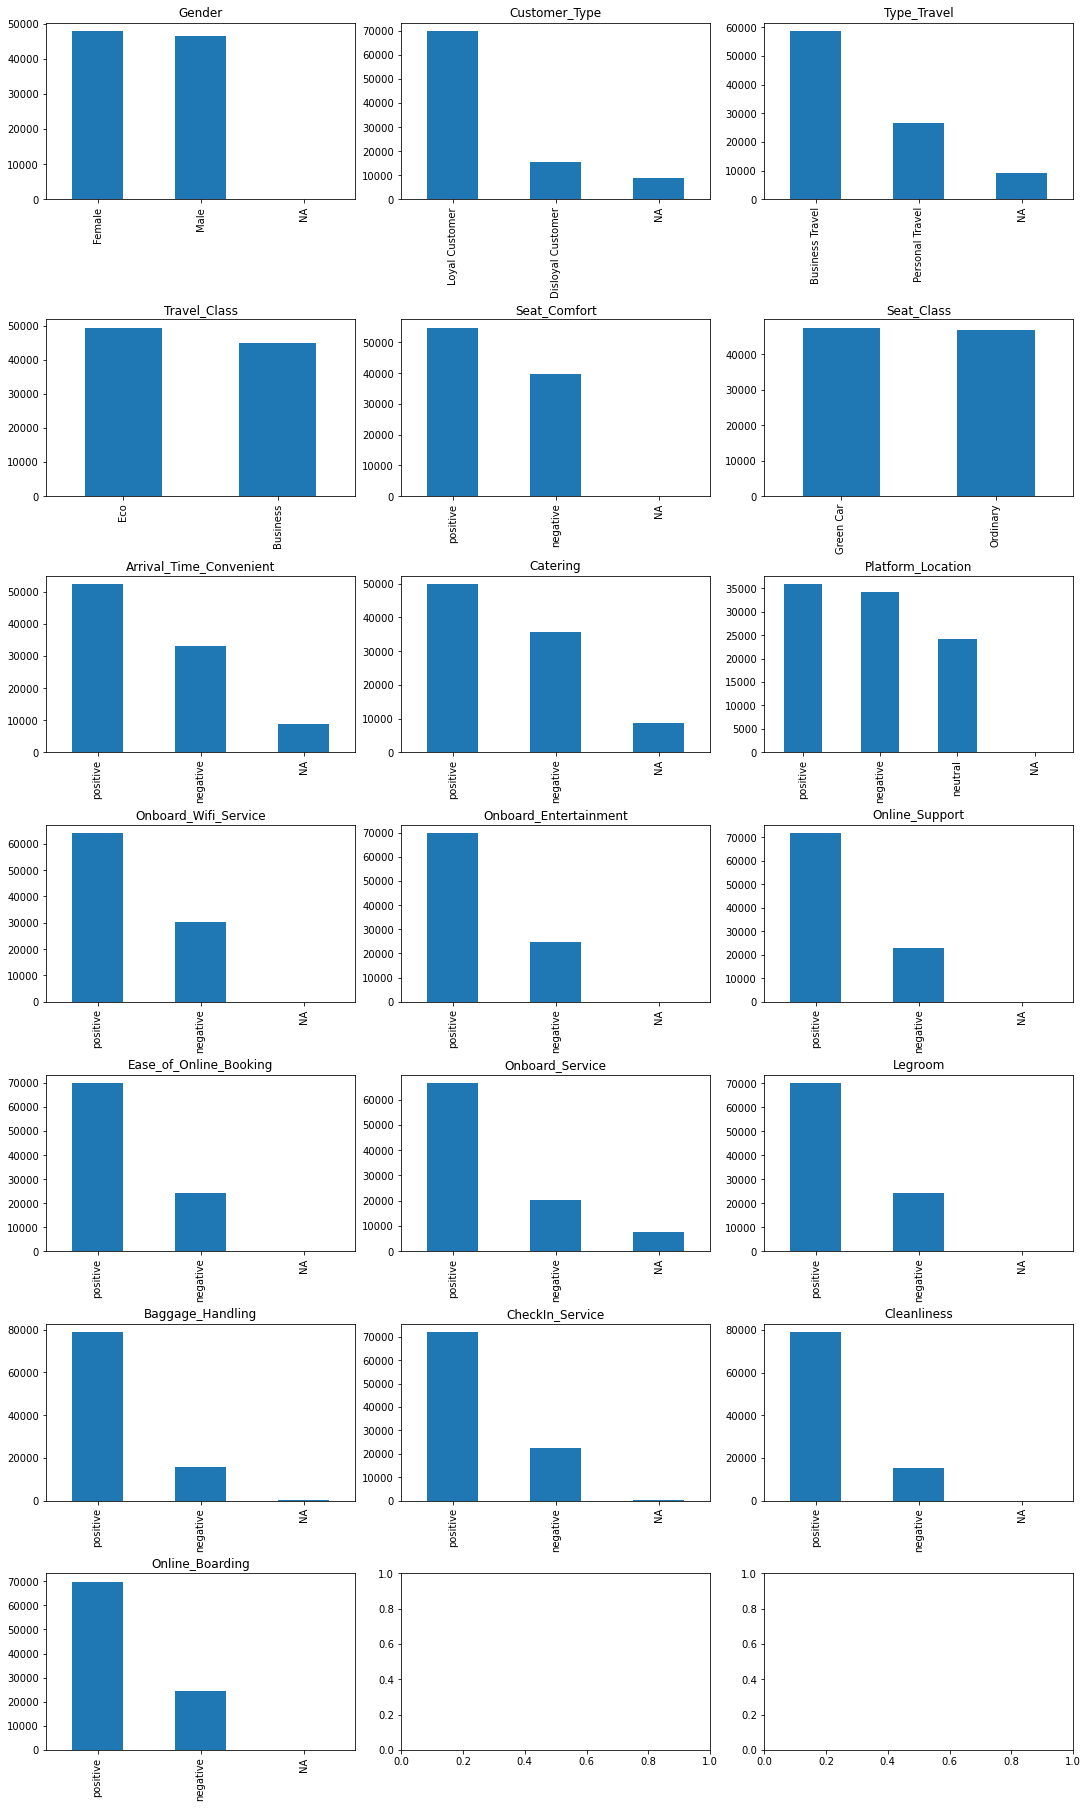

In [65]:
# assuming you have 21 columns:
fig,axes = plt.subplots(nrows=7, ncols=3, figsize=(15,25), constrained_layout=True)

# use `select_dtypes` to filter Object-type
for col, ax in zip(simple_train_df.select_dtypes(include='O'), axes.ravel()):
    simple_train_df[col].fillna('NA').value_counts().plot.bar(ax=ax)
    ax.set_title(col)
    
plt.show()